In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [26]:
data_dir = 'data/train'
# entries = os.listdir(data_dir)
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([# transforms.RandomRotation(30),  # data augmentations are great
                                       # transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize((300,300)),
                                       transforms.ToTensor(),
                                       # transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                                           # [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize((300,300)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=32)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=32)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['cat', 'dog']


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
print("TEAT")
for epoch in range(epochs):
    for inputs, labels in trainloader:
        print(steps)
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

TEAT
0
1
2
3
4
5
6
7
8
9
Epoch 1/1.. Train loss: 2.346.. Test loss: 1.438.. Test accuracy: 0.562
10
11
12
13
14
15
16
17
18
19
Epoch 1/1.. Train loss: 0.403.. Test loss: 0.603.. Test accuracy: 0.692
20
21
22
23
24
25
26
27
28
29
Epoch 1/1.. Train loss: 0.141.. Test loss: 0.877.. Test accuracy: 0.604
30
31
32
33
34
35
36
37
38
39
Epoch 1/1.. Train loss: 0.098.. Test loss: 1.028.. Test accuracy: 0.576
40
41
42
43
44
45
46
47
48
49
Epoch 1/1.. Train loss: 0.134.. Test loss: 1.989.. Test accuracy: 0.534
50
51
52
53
54
55
56
57
58
59
Epoch 1/1.. Train loss: 0.093.. Test loss: 3.503.. Test accuracy: 0.507
60
61
62
63
64
65
66
67
68
69
Epoch 1/1.. Train loss: 0.097.. Test loss: 1.240.. Test accuracy: 0.548
70
71
72
73
74


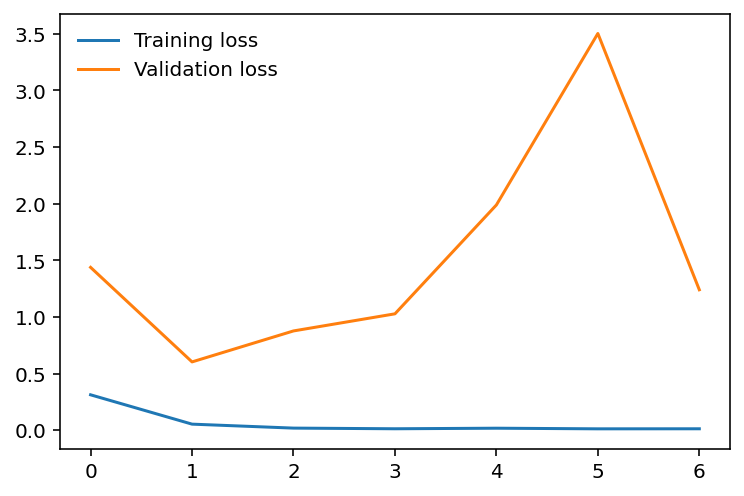

In [32]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [35]:
torch.save(model.state_dict(), "models/state_dict_model.pt")